In [2]:
from leecarter import leecarter
import pandas as pd

import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [7]:
filename = 'death_rates2_russia.txt'

mortality = pd.read_csv(filename, delim_whitespace=True)
mortality = mortality[mortality['Age'] != '110+']
mortality['Age'] = mortality['Age'].astype(int)
mortality['Year'] = mortality['Year'].astype(int)
mortality = mortality[mortality['Age'] <= 100]
mortality['Female_l'] = np.log(mortality['Female'].astype(float))
mortality['Male_l'] = np.log(mortality['Male'].astype(float))
mortality['Total_l'] = np.log(mortality['Total'].astype(float))
mortality = mortality[['Year', 'Age', 'Female_l', 'Male_l', 'Total_l']]
mortality

,Year,Age,Female_l,Male_l,Total_l
0,1959,0,-3.286272,-3.070736,-3.170419
1,1959,1,-5.053334,-4.988336,-5.019626
2,1959,2,-5.978351,-5.904920,-5.940011
3,1959,3,-6.454771,-6.341873,-6.395531
4,1959,4,-6.707266,-6.458592,-6.572713
...,...,...,...,...,...
6201,2014,96,-1.066663,-1.056384,-1.065127
6202,2014,97,-0.977443,-1.053325,-0.988109
6203,2014,98,-0.906543,-0.964867,-0.914670
6204,2014,99,-0.911368,-0.909725,-0.911134


In [8]:
# split train test
def fit_arima(matrix):
    d = []
    for a in range(5):
        for b in range(5):
            for c in range(5):
                try:
                    mod = ARIMA(matrix, order=(a,b,c))
                    res = mod.fit()
                    d.append([res.llf, a, b, c])
                except ConvergenceWarning:
                    pass

    print(d)
    return max(d)


def predict(matrix, column: str = 'Female_l', age = 65):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    fm_train = fm.iloc[:,0:round(np.shape(fm)[1]*2/3)]
    # fm_cross_val = fm.iloc[:,round(np.shape(fm)[1]*2/3):]
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    N = np.shape(fm)[0]
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)
    bxkt = S[0] * np.dot(U[:, 0].reshape(N, 1), V[0, :].reshape(T, 1).T)

    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    v, par1, par2, par3 = fit_arima(k_t)
    print(f'fit arima: {v, par1,par2,par3}')
    mod = ARIMA(k_t, order=(par1,par2,par3))
    # mod = ARIMA(k_t, order=(4,1,3))
    res = mod.fit()
    print(res.summary())

    pred = res.forecast(steps=21)
    print(pred)
    return np.exp(a_x[age] + b_x[age]*pred)

In [9]:
age = 65
column = 'Female_l'

In [10]:
vals = predict(mortality, column, age)

C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to conv

[[-104.65625823641511, 0, 0, 0], [-84.92318132903239, 0, 0, 1], [-71.71888695126805, 0, 0, 2], [-64.28137744097697, 0, 0, 3], [-62.090577735328424, 0, 0, 4], [-51.55581961764989, 0, 1, 0], [-49.42729319721565, 0, 1, 1], [-48.617718646752316, 0, 1, 2], [-47.35855291132166, 0, 1, 3], [-42.9409300934813, 0, 1, 4], [-53.384812521140105, 0, 2, 0], [-45.619263852667174, 0, 2, 1], [-44.86102243926316, 0, 2, 2], [-43.302111612679134, 0, 2, 3], [-42.57016320075233, 0, 2, 4], [-70.55142465188203, 0, 3, 0], [-54.10725527519992, 0, 3, 1], [-46.810900673081036, 0, 3, 2], [-46.109734913142304, 0, 3, 3], [-44.471934815794015, 0, 3, 4], [-88.16997749310244, 0, 4, 0], [-70.7238929380865, 0, 4, 1], [-56.490509300635296, 0, 4, 2], [-50.86297421615116, 0, 4, 3], [-49.87328197483485, 0, 4, 4], [-54.6208726962884, 1, 0, 0], [-52.42785119776688, 1, 0, 1], [-51.578733031176796, 1, 0, 2], [-50.457843491201245, 1, 0, 3], [-45.94628893049161, 1, 0, 4], [-48.42210429864765, 1, 1, 0], [-46.45048692539604, 1, 1, 1]

C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))
real_vals

,Year,Age,Female_l
65,1959,65,0.018629
176,1960,65,0.019112
287,1961,65,0.019281
398,1962,65,0.020495
509,1963,65,0.019887
620,1964,65,0.016403
731,1965,65,0.020985
842,1966,65,0.018580
953,1967,65,0.016807
1064,1968,65,0.017246


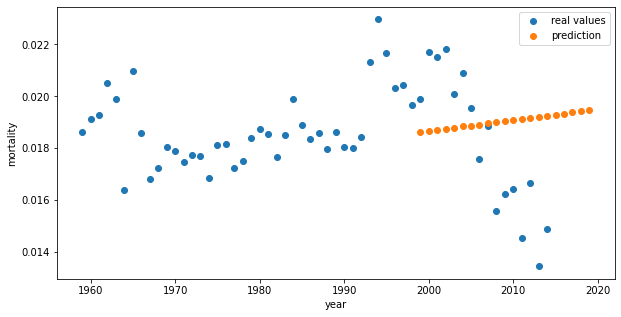

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
plt.xlabel('year')
plt.ylabel('mortality')
plt.legend()
plt.savefig('figure.svg')

In [43]:
# jak cos nie styka
# split train test
def fit_arima_error(matrix):
    d = []
    for a in range(5):
        for b in range(2):
            for c in range(5):
                try:
                    mod = ARIMA(matrix, order=(a,b,c))
                    res = mod.fit()
                    d.append([res.llf, a, b, c])
                except ConvergenceWarning:
                    pass
    return d


def predict_error(matrix, column: str = 'Female_l', age = 65):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    fm_train = fm.iloc[:,0:round(np.shape(fm)[1]*2/3)]
    # fm_cross_val = fm.iloc[:,round(np.shape(fm)[1]*2/3):]
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    N = np.shape(fm)[0]
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)
    bxkt = S[0] * np.dot(U[:, 0].reshape(N, 1), V[0, :].reshape(T, 1).T)

    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    d = fit_arima_error(k_t)
    for d_i in d:
        mod = ARIMA(k_t, order=(d_i[1],d_i[2],d_i[3]))
        # mod = ARIMA(k_t, order=(4,1,3))
        res = mod.fit()
        pred = res.forecast(steps=21)
        real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
        real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))


        plt.figure(figsize=(10,5))
        plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
        plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
        plt.xlabel('year')
        plt.ylabel('mortality')
        plt.legend()
        plt.show()


In [45]:
age = 65
column = 'Male_l'
# vals = predict_error(mortality, column, age)


C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive pa

[[-167.66312422766316, 0, 0, 0], [-146.54780936972588, 0, 0, 1], [-131.07980055411736, 0, 0, 2], [-123.03094701275066, 0, 0, 3], [-116.17355552968321, 0, 0, 4], [-98.06883778698668, 0, 1, 0], [-98.0477183529452, 0, 1, 1], [-94.55069142801155, 0, 1, 2], [-94.51979041612194, 0, 1, 3], [-94.34236811942102, 0, 1, 4], [-108.57453425561125, 0, 2, 0], [-91.91319451336196, 0, 2, 1], [-89.87083897740841, 0, 2, 2], [-89.63249961162501, 0, 2, 3], [-87.47426810467041, 0, 2, 4], [-127.69830351869885, 0, 3, 0], [-108.10697993927418, 0, 3, 1], [-92.31865984834232, 0, 3, 2], [-89.7716625478964, 0, 3, 3], [-89.56875032950038, 0, 3, 4], [-146.23114118428163, 0, 4, 0], [-126.61336760018484, 0, 4, 1], [-109.10587577739037, 0, 4, 2], [-95.22265117933708, 0, 4, 3], [-92.73060757228357, 0, 4, 4], [-102.7671265222081, 1, 0, 0], [-102.74158404970736, 1, 0, 1], [-99.30086039773595, 1, 0, 2], [-99.26930803716407, 1, 0, 3], [-99.12844982165183, 1, 0, 4], [-98.03366636069154, 1, 1, 0], [-93.7039321539181, 1, 1, 1]

C:\Users\piotr\projekty\diffusion_processes_on_complex_networks\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   41
Model:                 ARIMA(4, 2, 3)   Log Likelihood                 -85.583
Date:                Fri, 10 Jun 2022   AIC                            187.167
Time:                        14:47:25   BIC                            200.475
Sample:                             0   HQIC                           191.942
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0124      0.373     -0.033      0.973      -0.743       0.718
ar.L2         -0.0906      0.213     -0.426      0.670      -0.508       0.327
ar.L3         -0.5726      0.120     -4.768      0.0

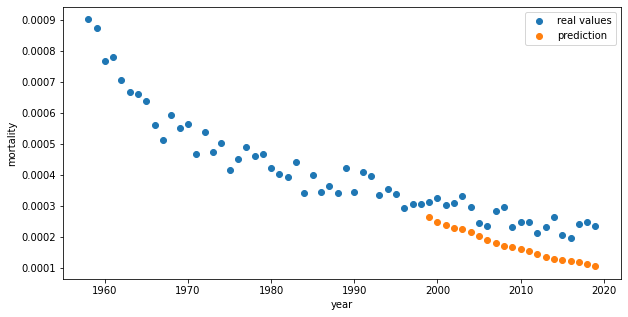

In [49]:
age = 20
column = 'Male_l'
vals = predict(mortality, column, age)
real_vals = mortality[mortality['Age']==age][['Year','Age',column]]
real_vals[column] = real_vals[column].apply(lambda x: np.exp(x))
plt.figure(figsize=(10,5))
plt.scatter(real_vals['Year'], real_vals[column], label = 'real values')
plt.scatter(np.arange(1999,2020,1), vals, label='prediction')
plt.xlabel('year')
plt.ylabel('mortality')
plt.legend()
plt.savefig('figure.svg')